In [5]:
import random

flatten = lambda l: [item for sublist in l for item in sublist]

class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP   ", "LEFT ", "DOWN ", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()

    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return [self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]]
        return flatten(self._get_grille(x, y))
    
    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """
        
        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 200:
            self.position = new_x, new_y
            return self._get_state(), -1, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

In [277]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam, sgd
import random
import time
import os

from collections import deque

class Trainer:
    def __init__(self, name=None, learning_rate=0.01, epsilon_decay=0.9999):
        self.state_size = 16
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        self.name = name
        
        if name is not None and os.path.isfile("model-" + name):
            model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(24, input_shape=(self.state_size,), activation='relu'))
            model.add(Dense(24, activation="relu"))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=sgd(lr=self.learning_rate))

        self.model = model       

    def get_best_action(self, state, rand=True):
        
        self.epsilon *= self.epsilon_decay

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array([state]))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(np.array([state]))[0]
        if done:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(self.model.predict(np.array([next_state])))

        inputs = np.array([state])
        outputs = np.array([target])

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=1)
        
    def save(self):
        if self.name:
            self.model.save("model-" + self.name, overwrite=True)
        else:
            self.model.save("model-" + str(time.time()))


In [357]:
import time 

def train(episodes, trainer, game):
    scores = []
    losses = [0]
    for e in range(episodes):
        state = game.reset()
        score = 0  # score in current game
        done = False
        steps = 0  # steps in current game
        while not done:
            steps += 1
            action = trainer.get_best_action(state)
            next_state, reward, done, _ = game.move(action)
            score += reward
            trainer.train(state, action, reward, next_state, done)
            #print(state.index(1), Game.ACTION_NAMES[action], reward, next_state.index(1), "DONE" if done else "")
            state = next_state
            if done:
                scores.append(score)
                break
            if steps > 200:
                trainer.train(state, action, -10, state, True) # we end the game
                scores.append(score)
                break
        if e % 100 == 0: # print log every 100 episode
            print("episode: {}/{}, moves: {}, score: {}"
                  .format(e, episodes, steps, score))
            print(f"epsilon : {trainer.epsilon}")
    #trainer.save()
    return scores

In [348]:
g = Game(4, 4, 0.1, alea=False)
g.print()
g._get_state()

....
..¤x
..o.
@...



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [373]:
trainer = Trainer(learning_rate=0.01)

In [374]:
score = train(2000, trainer, g)

episode: 0/2000, moves: 15, score: -24
epsilon : 0.9985010495451367
episode: 100/2000, moves: 16, score: -5
epsilon : 0.8286069177717583
episode: 200/2000, moves: 2, score: -11
epsilon : 0.6856288235318889
episode: 300/2000, moves: 29, score: -18
epsilon : 0.5748606117927146
episode: 400/2000, moves: 11, score: 0
epsilon : 0.5005565986989788
episode: 500/2000, moves: 16, score: -5
epsilon : 0.43424703238058443
episode: 600/2000, moves: 11, score: 0
epsilon : 0.3795198251868134
episode: 700/2000, moves: 14, score: -3
epsilon : 0.3354593093136318
episode: 800/2000, moves: 9, score: 2
epsilon : 0.2973751996328137
episode: 900/2000, moves: 12, score: -1
epsilon : 0.26348293143254886
episode: 1000/2000, moves: 16, score: -5
epsilon : 0.23408462005214803
episode: 1100/2000, moves: 8, score: 3
epsilon : 0.21079317380055498
episode: 1200/2000, moves: 5, score: 6
epsilon : 0.19691536725068923
episode: 1300/2000, moves: 5, score: 6
epsilon : 0.18347354594781293
episode: 1400/2000, moves: 13, sco

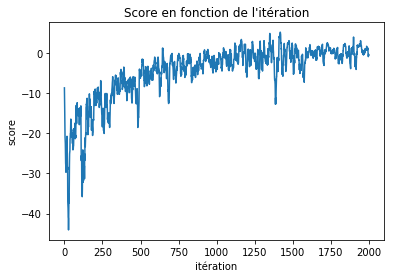

In [377]:
import matplotlib.pyplot as plt

score = np.array(score)
score_c = np.convolve(score, np.full((10,), 1/10), mode="same")

plt.plot(score_c)
plt.title("Score en fonction de l'itération")
plt.xlabel("itération")
plt.ylabel("score")
from IPython import display
plt.show()

In [382]:
from IPython import display
import time
state = g.reset()
#g.position = (0, 0)
state = g._get_state()
done = False

g.print(); time.sleep(3)
while not done:
    time.sleep(1)
    #print(trainer.model.predict(np.array([g._get_state()])))
    action = trainer.get_best_action(g._get_state(), rand=False)
    #print(Game.ACTION_NAMES[action])
    next_state, reward, done, _ = g.move(action)
    display.clear_output(wait=True)
    g.print()

....
..¤.
..o.
x...



In [376]:
state = g.reset()
state = g._get_state()
done = False
g.print()
while not done:
    time.sleep(1)
    print(trainer.model.predict(np.array([g._get_state()])))
    action = trainer.get_best_action(g._get_state(), rand=False)
    print(Game.ACTION_NAMES[action])
    next_state, reward, done, _ = g.move(action)
    g.print()

....
..¤x
..o.
@...

[[-1.34637856 -2.11158776 -1.76328325 -1.93712187]]
UP   
...x
..¤.
..o.
@...

[[-1.23143804 -0.11533874 -1.622473   -1.48908067]]
LEFT 
....
..¤x
..o.
@...

[[-1.34637856 -2.11158776 -1.76328325 -1.93712187]]
UP   
....
..¤x
..o.
@...

[[-1.34637856 -2.11158776 -1.76328325 -1.93712187]]
UP   
...x
..¤.
..o.
@...

[[-1.23143804 -0.11533874 -1.622473   -1.48908067]]
LEFT 
..x.
..¤.
..o.
@...

[[-0.38794243  1.00863743 -0.14014438 -1.01609373]]
LEFT 
..x.
..¤.
..o.
@...

[[-0.38794243  1.00863743 -0.14014438 -1.01609373]]
LEFT 
.x..
..¤.
..o.
@...

[[ 0.73610997  2.31064224  2.24244165  0.35037768]]
LEFT 
....
.x¤.
..o.
@...

[[ 1.64516962  4.08249378  3.98241162  2.46510363]]
LEFT 
....
x.¤.
..o.
@...

[[ 2.82284212  5.18137836  6.16766834  2.77443981]]
DOWN 
....
x.¤.
..o.
@...

[[ 2.82284212  5.18137836  6.16766834  2.77443981]]
DOWN 
....
..¤.
x.o.
@...

[[ 4.4193902   6.79397774  8.80730247  4.67391729]]
DOWN 
....
..¤.
..o.
x...



In [ ]:
state = flatten(g._get_grille(0, 1))
print(state)
trainer.model.predict(np.array([state]))

In [26]:
g._get_state()

10